### Задание 1
Создадим функцию `rand` реализующую мультипликативный метод генерации последовательности случайных чисел

Зададим параметры $a = 22695477, b = 1, m = 2^{32}$

In [248]:
import numpy as np
import numba as nb


def prepare_rand(a: np.int64, b: np.int64, m: np.int64):
    @nb.njit(fastmath=True)
    def rand(x_i: np.int64) -> np.int64:
        return (a * x_i + b) % m

    return rand


a = 22695477
b = 1
m = 2**32

rand = prepare_rand(a, b, m)


### Задание 2
Сгенерируем последовательности в интервале от $A = 0$; до $B = 10$

In [249]:
def prepare_rand_vec(
    x_0: np.int64, A: np.int64, B: np.int64, N: np.int64, out: np.ndarray[np.float64]
) -> np.ndarray[np.float64]:
    cur_x = x_0
    numbers = []

    for _ in range(N):
        cur_x = rand(cur_x)
        numbers.append(cur_x)

    out[: len(numbers)] = numbers
    out = A + (B - A) * (out / m)

    return out


A = 0
B = 10
vec_N = np.array([100, 1000, 10000, 100000])

series = np.array(
    [prepare_rand_vec(1, A, B, n, np.zeros(100000)) for n in vec_N],
)


### Задание 3
Рассчитаем математическое ожидание равномерно распределенной случайной величины и их погрешности для последовательности случайных чисел

In [250]:
M = A + B / 2
D = (B - A) ** 2 / 12


M_e = np.sum(series, axis=1) / vec_N
D_e = ((np.sum(series**2, axis=1) / vec_N) - M_e**2) * (vec_N / (vec_N - 1))

Eps_M_e = np.abs((M - M_e) / M) * 100
Eps_D_e = np.abs((D - D_e) / D) * 100

print(f"M_e: {M_e}")
print(f"D_e: {D_e}")
print(f"Eps_M_e: {Eps_M_e}")
print(f"Eps_D_e: {Eps_D_e}")


M_e: [4.84468678 5.08284367 4.99701632 4.99230021]
D_e: [8.18603841 8.12764896 8.30805367 8.34433389]
Eps_M_e: [3.10626446 1.65687337 0.0596737  0.15399589]
Eps_D_e: [1.76753911 2.46821248 0.30335593 0.13200673]


### Задание 4
Создадим функцию `rand_period`, определяющую период сгенерированной последовательности случайных чисел

Проведем тестирование последовательностей на периодичность

In [251]:
EPS = 0.00000001


@nb.njit(parallel=True)
def rand_period(series: np.ndarray, size: int) -> np.ndarray:
    result = np.linspace(-1, -1, 3).astype(np.int64)

    for i in nb.prange(size):
        for j in nb.prange(i, size):
            if np.abs(series[i] - series[j]) <= EPS and i != j:
                result[0] = j - i
                result[1] = i
                result[2] = j
                return result

    return result


for i, (c_series, n) in enumerate(zip(series, vec_N), 1):
    p = rand_period(c_series, n)
    print(f"Последовательность {i}: {p}")


Последовательность 1: [-1 -1 -1]
Последовательность 2: [-1 -1 -1]
Последовательность 3: [-1 -1 -1]
Последовательность 4: [95294  2083 97377]


### Задание 5
Реализуем функцию `get_freq_distr` определения относительных частот случайных чисел по известной выборке

In [252]:
@nb.njit(fastmath=True)
def get_freq_distr(
    series: np.ndarray,
    series_size: np.int64,
    a: np.int64,
    b: np.int64,
    intervals_count: np.int64,
) -> np.ndarray[np.float64]:
    delta = (b - a) / intervals_count
    freq = np.zeros(intervals_count)
    f_n = np.floor((series[:series_size] / delta)).astype(np.int64)

    for i in range(f_n.size):
        freq[f_n[i]] += 1

    freq = freq / (series_size * delta)

    return freq


### Задание 6
С использованием функции определения относительных частот построим гистограммы относительных частот для последовательности случайных чисел на 10 участках.

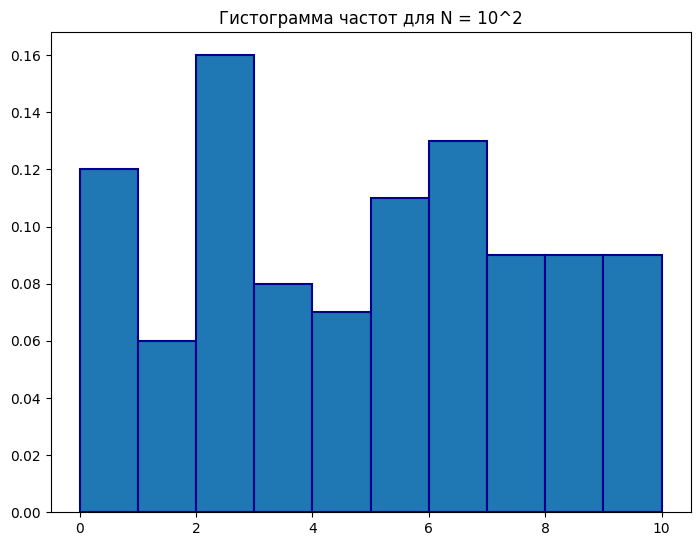

Критерий Пирсона для N = 10^2: 8.152e-02


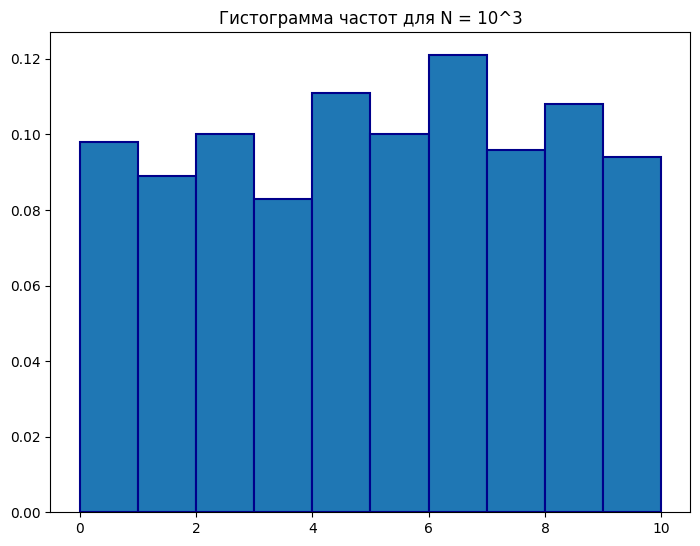

Критерий Пирсона для N = 10^3: 1.076e-02


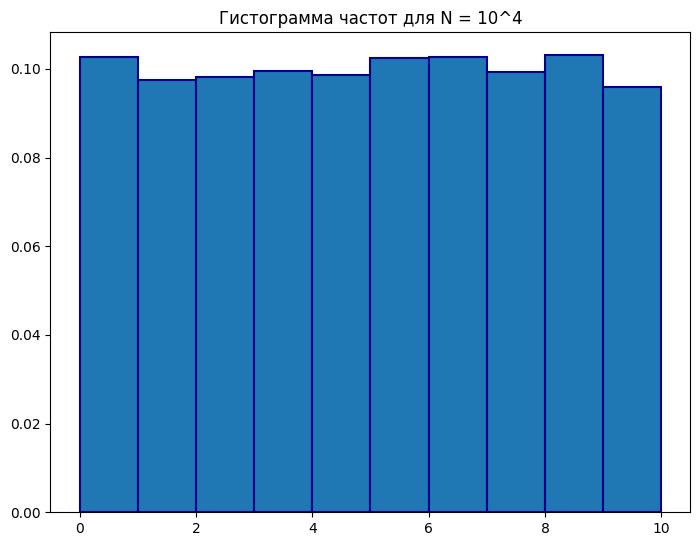

Критерий Пирсона для N = 10^4: 5.888e-04


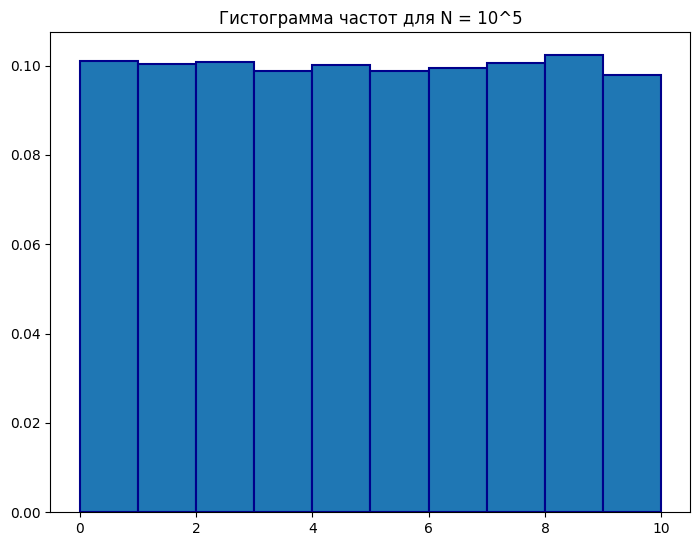

Критерий Пирсона для N = 10^5: 1.512e-04


In [253]:
import matplotlib.pyplot as plt

K = 10

resX = np.linspace(0.5, 9.5, 10)

for i, (c_series, n) in enumerate(zip(series, vec_N), 1):

    resY = get_freq_distr(c_series, n, A, B, K)

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.bar(resX, resY, align="center", width=1, edgecolor="darkblue", linewidth=1.5)
    plt.title(f"Гистограмма частот для N = 10^{1+i}")
    plt.show()

    pirson_res = np.sum((((1 / K) - resY) ** 2) / resY)
    print(f"Критерий Пирсона для N = 10^{1+i}: {pirson_res:.3e}")


### Задание 7
Проделать операции 2-6 для встроенного генератора случайных чисел

#### 7.2

In [254]:
A = 0
B = 10
vec_N = np.array([100, 1000, 10000, 100000])

series = np.array([(B - A) * np.random.random_sample(100000) for _ in range(4)])


#### 7.3

In [255]:
M = A + B / 2
D = (B - A) ** 2 / 12


M_e = np.sum(series, axis=1) / vec_N
D_e = ((np.sum(series**2, axis=1) / vec_N) - M_e**2) * (vec_N / (vec_N - 1))

Eps_M_e = np.abs((M - M_e) / M) * 100
Eps_D_e = np.abs((D - D_e) / D) * 100

print(f"M_e: {M_e}")
print(f"D_e: {D_e}")
print(f"Eps_M_e: {Eps_M_e}")
print(f"Eps_D_e: {Eps_D_e}")

M_e: [5.01299978e+03 5.02017529e+02 5.00957580e+01 4.99476253e+00]
D_e: [-2.53501698e+07 -2.48917657e+05 -2.17561301e+03  8.32272494e+00]
Eps_M_e: [1.00159996e+05 9.94035059e+03 9.01915161e+02 1.04749380e-01]
Eps_D_e: [3.04202138e+08 2.98711189e+06 2.62073561e+04 1.27300692e-01]


#### 7.4

In [258]:
for i, (c_series, n) in enumerate(zip(series, vec_N), 1):
    p = rand_period(c_series, n)
    print(f"Последовательность {i}: {p}")


Последовательность 1: [-1 -1 -1]
Последовательность 2: [-1 -1 -1]
Последовательность 3: [-1 -1 -1]
Последовательность 4: [41536  7018 48554]


#### 7.6

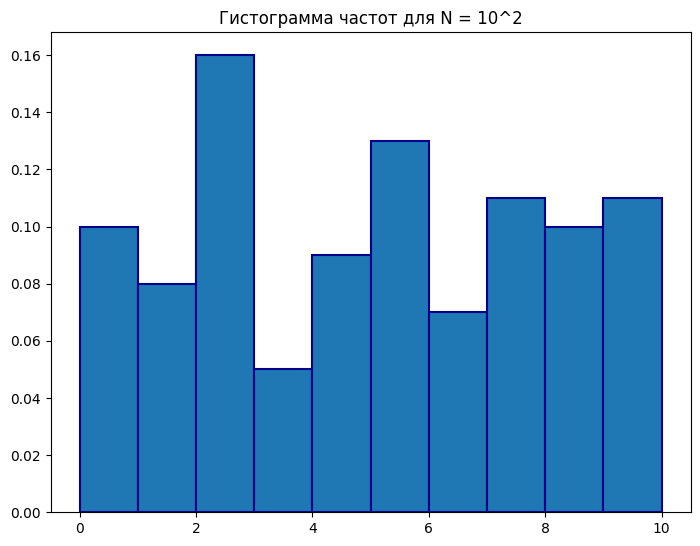

Критерий Пирсона для N = 10^2: 1.002e-01


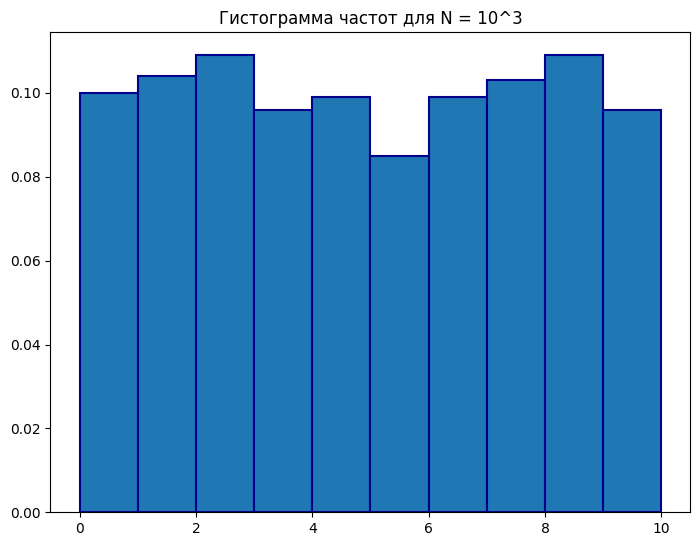

Критерий Пирсона для N = 10^3: 4.728e-03


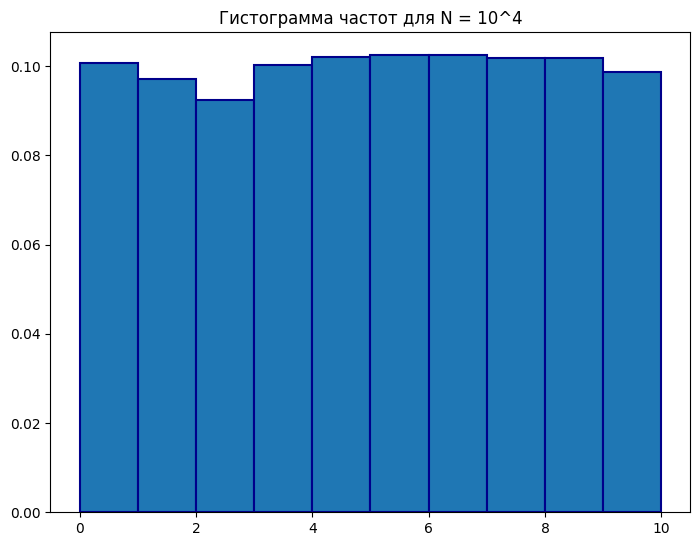

Критерий Пирсона для N = 10^4: 9.637e-04


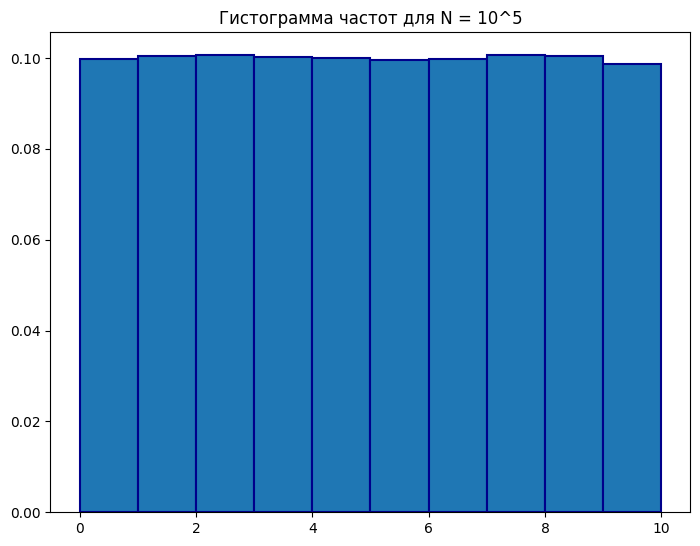

Критерий Пирсона для N = 10^5: 3.195e-05


In [257]:
for i, (c_series, n) in enumerate(zip(series, vec_N), 1):

    resY = get_freq_distr(c_series, n, A, B, K)

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.bar(resX, resY, align="center", width=1, edgecolor="darkblue", linewidth=1.5)
    plt.title(f"Гистограмма частот для N = 10^{1+i}")
    plt.show()

    pirson_res = np.sum((((1 / K) - resY) ** 2) / resY)
    print(f"Критерий Пирсона для N = 10^{1+i}: {pirson_res:.3e}")